In [1]:
using DrWatson
quickactivate(@__DIR__)
Base.LOAD_PATH .= findproject(@__DIR__);

import Baysor as B
import BaysorAnalysis as BA

import CairoMakie as MK
import Colors
import CSV
import Clustering
import Images
import MultivariateStats
import Plots
import PlotThemes
import PyPlot as Plt
import Seaborn as Sns

import ColorSchemes
import Distances
import Random

using DataFrames
using DataFramesMeta
using NearestNeighbors
using ProgressMeter
using RCall
using SparseArrays
using Statistics
using StatsBase
using StatsPlots

ProgressMeter.ijulia_behavior(:clear);
MK.activate!(type = "png");
BA.set_pyplot_defaults!()
cplotsdir(args...) = plotsdir("benchmarking", "merfish_hypothalamus", args...);

In [2]:
color_per_label = BA.method_palette();

color_per_label["Paper"] = color_per_label["Watershed"];
delete!(color_per_label, "Watershed");

In [3]:
@time data = BA.load_merfish(paper_polygons=false, dapi=true, watershed=false, pciseq=false);

 29.708618 seconds (40.11 M allocations: 5.186 GiB, 5.24% gc time, 33.12% compilation time)


## Estimate QC

In [7]:
cell_cols = [:cell, :cell_paper];
BA.append_matching_statistics!(data, cell_cols);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


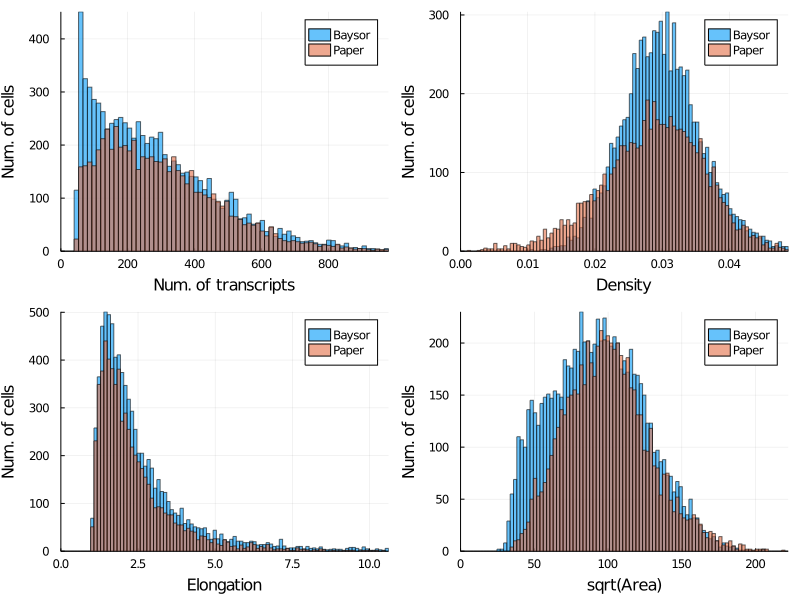

In [8]:
BA.plot_qc_comparison([data[:qc_per_cell_dfs][k] for k in cell_cols]; max_quants=[0.995, 0.99, 0.99, 0.999, 0.99], 
    labels=["Baysor", "Paper"])

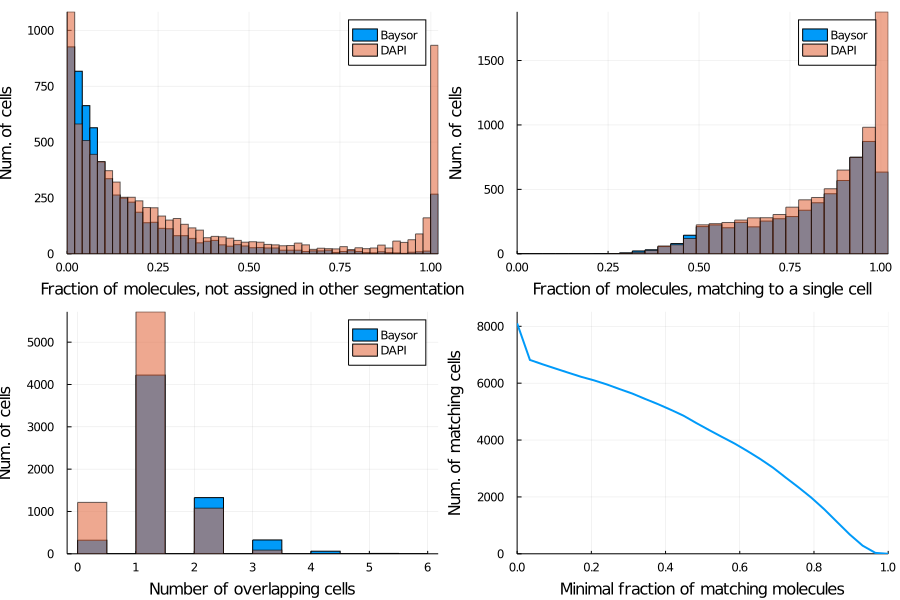

In [9]:
BA.plot_matching_comparison(data[:match_res_paper_cell])

### Embeddings

In [10]:
@time cms = Dict(cq => B.convert_segmentation_to_counts(data[:df].gene, data[:df][!, cq])[:, qdf.cell_id] for (cq, qdf) in data[:qc_per_cell_dfs]);
@time umaps, umap_merged, cm_merged = BA.estimate_embedding([cms[k] for k in cell_cols]...; n_pcs=20, metric=Euclidean(), spread=4);

  0.838633 seconds (914.89 k allocations: 94.466 MiB, 17.19% gc time, 94.59% compilation time)
 56.037358 seconds (30.80 M allocations: 2.283 GiB, 0.73% gc time, 26.06% compilation time)


In [11]:
@time umaps, umap_merged, cm_merged = BA.estimate_embedding([cms[k] for k in cell_cols]...; n_pcs=20, metric=Euclidean(), spread=5);

 53.501193 seconds (2.07 M allocations: 742.626 MiB, 0.29% gc time, 0.40% compilation time)


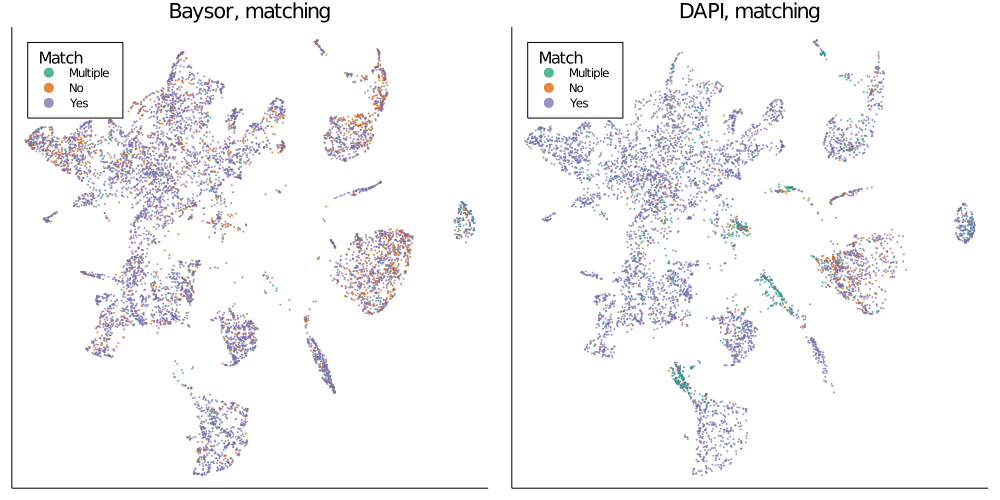

In [12]:
BA.plot_qc_embeddings([data[:qc_per_cell_dfs][k] for k in cell_cols], data[:match_res_cell_paper], umaps, legend=:topleft, size=(1000, 500), 
    plot_num_transcripts=false, layout=(1,2), palette=ColorSchemes.Dark2_3, ms=1.5, alpha=0.75, ticks=false)

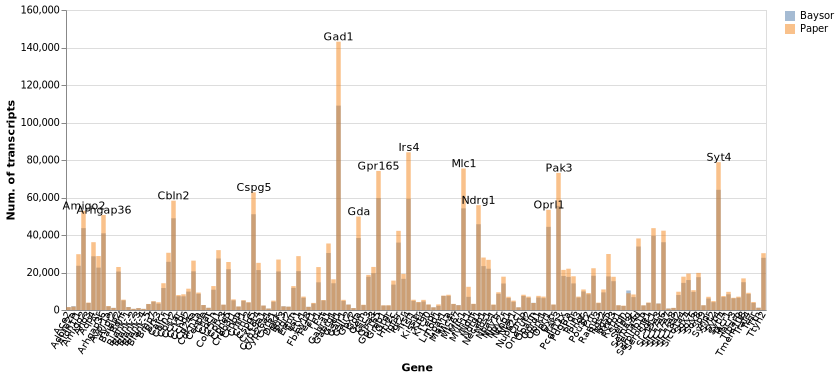

In [13]:
BA.plot_expression_vec_comparison(data[:df], data[:qc_per_cell_dfs], data[:gene_names], 
    min_expr_frac=0.02, text_offset=0.001,
    xticks=true, ylabel="Num. of transcripts", labels=["Baysor", "Paper"])

## Annotation

In [4]:
@rimport CellAnnotatoR
R"""
library(Matrix)
library(CellAnnotatoR)
library(magrittr)
library(ggplot2)
library(ggrepel)

theme_set(theme_bw())
""";

In [15]:
clusts = Clustering.hclust(Distances.pairwise(Euclidean(), B.transform(umap_merged.pca_transform, cm_merged), dims=2); linkage=:ward);

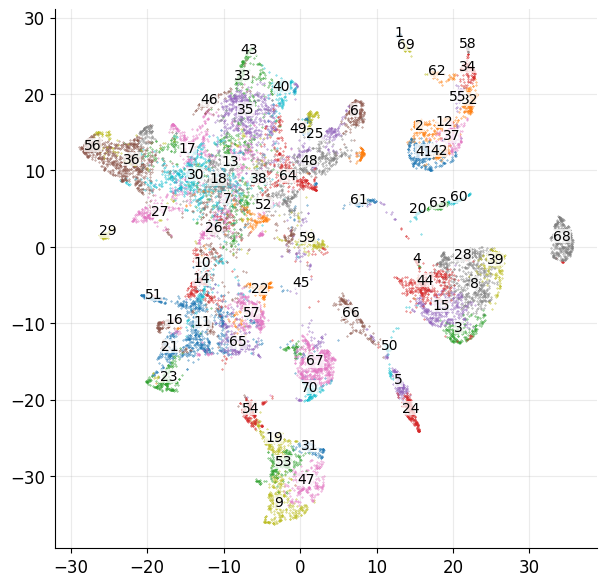

PyObject <AxesSubplot:>

In [16]:
cell_names = ["c$i" for i in 1:size(umap_merged.embedding, 2)];
c_clusts = Clustering.cutree(clusts, k=70)

Plt.figure(figsize=(7, 7))
BA.plot_embedding(umap_merged.embedding, c_clusts, s=0.1)

In [17]:
cm_merged_r = hcat([cms[k] for k in cell_cols]...)
cell_names = ["c$i" for i in 1:R"ncol"(cm_merged_r)[1]]
cm_merged_r = R"`rownames<-`"(cm_merged_r, data[:gene_names]);
cm_merged_r = R"`colnames<-`"(cm_merged_r, cell_names);

cm_norm = CellAnnotatoR.normalizeTfIdfWithFeatures(cm_merged_r);

In [18]:
clf_data = CellAnnotatoR.getClassificationData(cm_norm, projectdir("metadata/markers/merfish_hypothalamus.txt"), prenormalized=true);
ann_by_level_spatial = rcopy(CellAnnotatoR.assignCellsByScores(nothing, clf_data, verbose=false, clusters=R"setNames"(c_clusts, cell_names)))[:annotation];

┌ Warning: RCall.jl: Warning in (function (cm, markers, prenormalized = F, data.gene.id.type = "SYMBOL",  :
│   Dropped 1 genes missed from the dataset. 17 marker genes left.
│ 
└ @ RCall /home/vpetukhov/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in expandAnnotationToClusters(scores, clusters) :
│   After cluster expansion, the following types are missed: Endothelial 2. Possible clusters for increasing resolution: 12, 41, 34, 32, 37, 55, 2, 42
└ @ RCall /home/vpetukhov/.julia/packages/RCall/eRsxl/src/io.jl:160


In [35]:
emb = R"$(umap_merged.embedding) %>% t() %>% as.data.frame() %>% set_rownames($cell_names)";
@time R"""
gg <- CellAnnotatoR::plotSubtypeMarkers($emb, t($cm_norm), clf.data=$clf_data, size=0.2, raster=TRUE, 
    raster.dpi=150, n.col=4, plot.na=FALSE) # , max.depth=1
ggsave("./mefish_markers.pdf", width=10, height=25)
print(getwd())
""";

[1] "/home/vpetukhov/spatial/BaysorAnalysis/notebooks/benchmarking"
  6.650862 seconds (4.03 k allocations: 255.000 KiB, 0.05% compilation time)


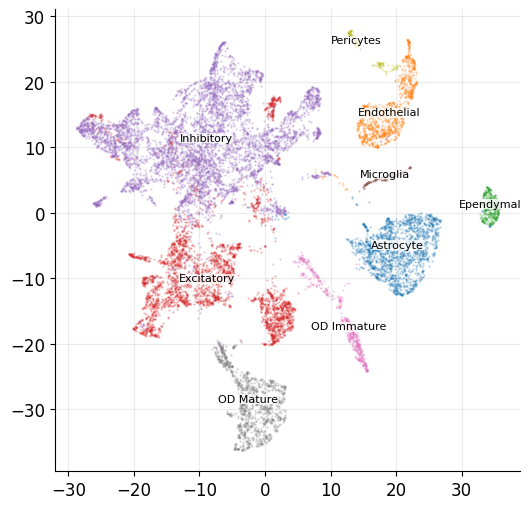

In [19]:
Plt.figure(figsize=(6, 6))
BA.plot_embedding(umap_merged.embedding, ann_by_level_spatial[:l1], s=0.5, alpha=0.25, fontsize=8);

### Plotting annotated data

In [20]:
c_annot = ann_by_level_spatial[:l1];
seg_type_per_cell = vcat(repeat([1], inner=size(umaps[1],2)), repeat([2], inner=size(umaps[2], 2)));
annot_labels = sort(unique(c_annot));
n_cells_per_type = [B.count_array(denserank(c_annot)[ids]) for ids in B.split_ids(seg_type_per_cell)];

missed_props = ["$v" for v in round.(Int, (1 .- n_cells_per_type[2] ./ n_cells_per_type[1]) .* 100)];

p_df = vcat([DataFrame(:n => n, :seg => s, :t => annot_labels) for (n, s) in zip(n_cells_per_type, ["Baysor", "Paper"])]...);

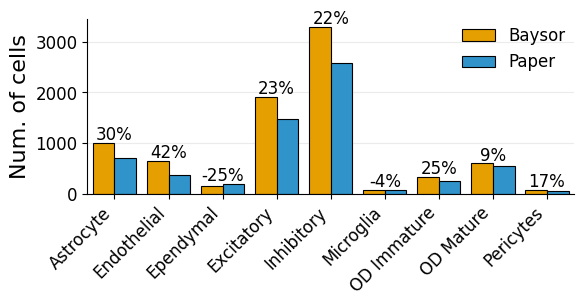

In [244]:
plt = Plt.figure(figsize=(6, 3.2))
ax = Sns.barplot(x=p_df.t, y=p_df.n, hue=p_df.seg, palette=color_per_label, edgecolor="black", linewidth=0.8, saturation=1)
for (x, y, t) in zip((1:length(annot_labels)) .- 1, max.(n_cells_per_type...), missed_props)
    Plt.annotate("$t%", (x, y + 60), horizontalalignment="center")
end

ax.set_ylabel("Num. of cells")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12);

Plt.tight_layout()
Plt.savefig(cplotsdir("num_cells_per_type.pdf"), transparent=true)

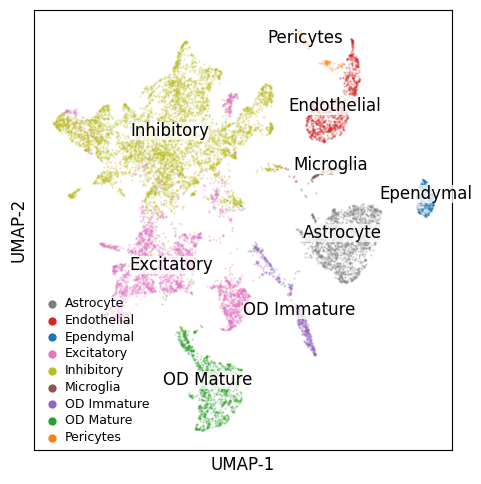

In [368]:
p_cols = Random.shuffle("#" .* Colors.hex.(ColorSchemes.tab10[1:10]));

plt = Plt.figure(figsize=(5, 5))
Plt.xticks([]); Plt.yticks([])
ax = BA.plot_embedding(umap_merged.embedding, ann_by_level_spatial[:l1], s=0.5, alpha=0.25, fontsize=12, palette=p_cols)
ax.spines["right"].set_visible(true); ax.spines["top"].set_visible(true);
ax.set_xlabel("UMAP-1", fontsize=12); ax.set_ylabel("UMAP-2", fontsize=12)

leg = ax.legend(loc="lower left", ncol=1, markerscale=7, fontsize=9, borderpad=0, 
    labelspacing=0.3, columnspacing=0.5, handletextpad=0, framealpha=0.6, facecolor="white", frameon=true)
leg.get_frame().set_linewidth(0.0)
for lh in leg.legendHandles
    lh.set_alpha(1)
end

Plt.tight_layout()
Plt.savefig(cplotsdir("embedding_annot.pdf"), transparent=true)

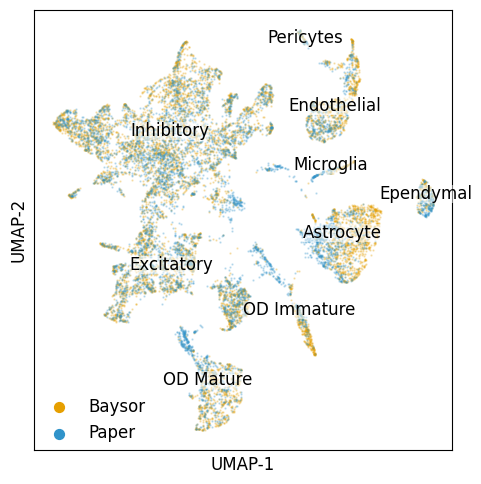

In [369]:
p_cols = [color_per_label[k] for k in ["Baysor", "Paper"]]

plt = Plt.figure(figsize=(5, 5))
Plt.xticks([]); Plt.yticks([])
ax = BA.plot_embedding(umap_merged.embedding, ["Baysor", "Paper"][seg_type_per_cell], s=0.5, alpha=0.25, mark_groups=false, palette=p_cols)
ax.spines["right"].set_visible(true); ax.spines["top"].set_visible(true);
ax.set_xlabel("UMAP-1", fontsize=12); ax.set_ylabel("UMAP-2", fontsize=12)

ids_per_clust = B.split_ids(denserank(ann_by_level_spatial[:l1]))
clust_centers = hcat([median(umap_merged.embedding[:, ids], dims=2) for ids in ids_per_clust]...);
bbox_style = Dict(:facecolor=>"white", :alpha=>0.5, :edgecolor=>"none", :pad=>0.0)
for (t, x, y) in zip(annot_labels, clust_centers[1,:], clust_centers[2,:])
    ax.annotate(t, (x,y), horizontalalignment="center", fontsize=12, bbox=bbox_style)
end

leg = ax.legend(loc="lower left", markerscale=10)
for lh in leg.legendHandles
    lh.set_alpha(1)
end

Plt.tight_layout()
Plt.savefig(cplotsdir("embedding_source.pdf"), transparent=true)

In [219]:
expr_per_clust = hcat([mean(cm_merged[:, ids] ./ sum(cm_merged[:,ids], dims=1), dims=2) for ids in ids_per_clust]...);
expr_per_clust ./= sum(expr_per_clust, dims=2);

ent_per_gene = mapslices(entropy, expr_per_clust, dims=2);
gene_mask = vec(ent_per_gene .< 1.7);
gene_sub = sortperm(maximum(expr_per_clust, dims=2)[:], rev=true)[1:25];

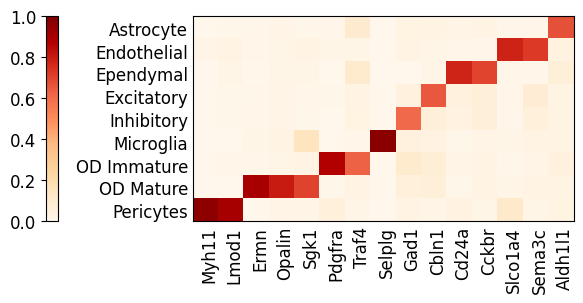

In [245]:
gene_sub = sortperm(maximum(expr_per_clust, dims=2)[:], rev=true)[1:15];
fig, (cax, ax) = Plt.subplots(ncols=2, figsize=(6, 3.2),  gridspec_kw=Dict("width_ratios" => [0.03, 1]))

plt, cell_ord, gene_ord = BA.clustermap(expr_per_clust[gene_sub, :], data[:gene_names][gene_sub],
    diag_genes=true, cell_ord=1:size(expr_per_clust, 2), cmap=:OrRd, rasterized=true, cbar=false, ax=ax,
    vmin=0.0, vmax=1.0
)

fig.colorbar(ax.get_children()[1], cax=cax, orientation="vertical")
cax.yaxis.set_ticks_position("left")

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12, ha="right");
ax.set_yticks(1:length(cell_ord))
ax.set_yticklabels(annot_labels[cell_ord], fontsize=12, rotation=0, va="bottom")
[ax.spines[k].set_visible(true) for k in keys(ax.spines)];

ax.tick_params(axis="both", which="both",length=0)
Plt.tight_layout()
Plt.savefig(cplotsdir("cluster_expression.pdf"), transparent=true)

In [286]:
cell_coords = hcat([[mean(df.x), mean(df.y)] for df in B.split(data[:df], data[:df].cell .+ 1)[2:end] if size(df, 1) > 10]...);

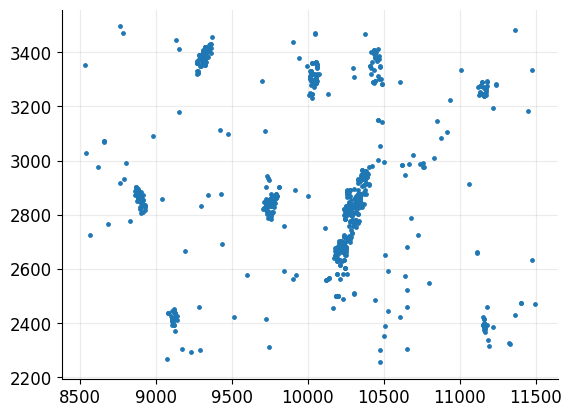

PyObject <matplotlib.collections.PathCollection object at 0x7feec27497c0>

In [301]:
p_df = @where(data[:df], :x .< 11500, :x .> 8500, :y .< 3500, :y .> 2250, :gene_name .== "Slco1a4");
Plt.scatter(p_df.x, p_df.y, s=6)

### ScanPy

In [212]:
# using PyCall

# @pyimport pandas as PD;
# @pyimport scanpy as SC;

# obs = PD.DataFrame(ann_by_level_spatial, index=["c$i" for i in 1:size(cm_merged, 2)])
# adata = SC.AnnData(hcat([cms[k] for k in cell_cols]...)', var=PD.DataFrame([], index=data[:gene_names]), 
#     obs=obs, obsm=Dict("X_pca" => copy(umap_merged.embedding')))
# #     obs=obs, obsm=Dict("X_pca" => PD.DataFrame(umap_merged.embedding', columns=["X", "Y"], index=obs.index)))

# adata.write_h5ad(projectdir("cache/merfish_hypothalamus_scanpy.h5ad"))

## Examples

### All

In [310]:
ids_per_clust = B.split_ids(denserank(c_annot)[1:size(umaps[1], 2)]);
t_clusts = findall(in.(annot_labels, Ref(["Astrocyte", "Endothelial", "Ependymal"])))

t_noise_ids = filter.(x -> data[:match_res_cell_paper].match_noise[1][x], ids_per_clust[t_clusts]);

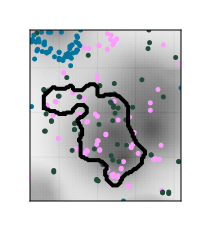

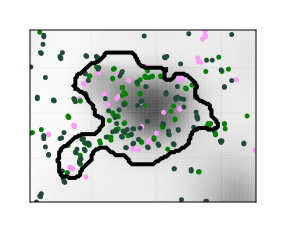

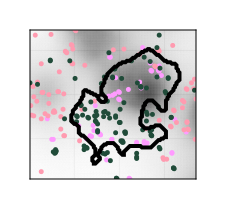

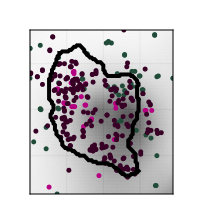

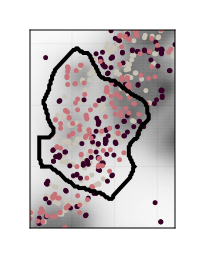

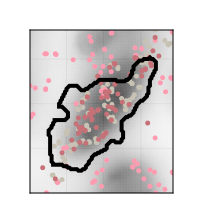

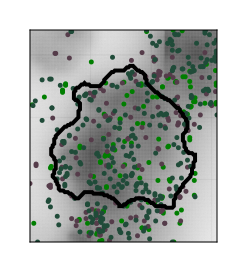

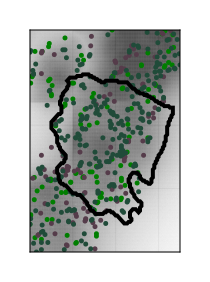

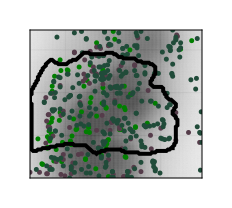

In [267]:
ann_colors = B.distinguishable_colors(data[:gene_names]);
ann_colors = Dict(Pair.(ann_colors[:ticks], ann_colors[:colors]));

for t_ids in t_noise_ids
    n_printed = 0
    for i in t_ids
        n_printed < 3 || break

        cur_cell = data[:qc_per_cell_dfs][:cell].cell_id[i]
        (xs, xe), (ys, ye) = BA.cell_coord_frame(data[:df], cur_cell, offset=0.2);
        
        min(xe - xs, ye - ys) > 200 || continue
        maximum(data[:dapi_arr][ys:ye, xs:xe]) > 0 || continue
        
        c_df = @where(data[:df], :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye)
        t_pol = B.boundary_polygons(c_df, ifelse.(c_df.cell .== cur_cell, c_df.cell, 0), bandwidth=10.0, grid_step=2.0, dens_threshold=1e-3)
        if length(t_pol) > 0
            pol_id = findmax(size.(t_pol, 1))[2]
            t_pol = t_pol[pol_id:pol_id]
        end
        
        gene_subs = sortperm(B.count_array(c_df.gene), rev=true)[1:3]
        c_df = @where(c_df, in.(:gene, Ref(gene_subs)))
        f_name = "$(c_annot[i]) $(n_printed + 1)"
        
        for (ext, leg) in ["png" => false, "pdf" => true]
            plt = BA.plot_subset(c_df, data[:dapi_arr], (xs, xe), (ys, ye), annotation=data[:gene_names][c_df.gene], 
                polygons=t_pol, noise=false, polygon_line_width=4.0,
                plot_raw_dapi=false, size_mult=1.0, markersize=5.0, title="", ann_colors=ann_colors, ticks=false,
                legend_kwargs=(position=:lt, labelsize=16, padding=(0,5,0,0), patchlabelgap=1, rowgap=0),
                legend=leg, plot_bg_dapi=!leg)
            MK.save(cplotsdir("examples", "$(f_name).$(ext)"), plt)
            leg || display(plt)
        end
        n_printed += 1
    end
end

### Ependymal

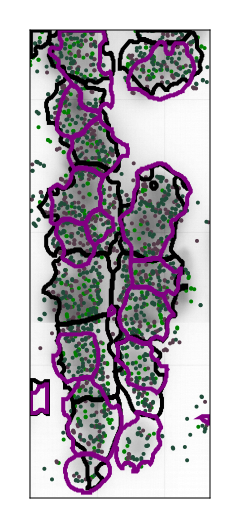

In [372]:
size_mult = 0.6
# xs, xe = (7950, 8500)
# ys, ye = (7000, 9000)
xs, xe = (7950, 8350)
ys, ye = (7220, 8100) # 8500

c_df = @where(data[:df], :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye)
t_pol = B.boundary_polygons(c_df, c_df.cell_paper, bandwidth=10.0, grid_step=2.0, dens_threshold=1e-3)
t_pol_b = B.boundary_polygons(c_df, c_df.cell, bandwidth=10.0, grid_step=2.0, dens_threshold=1e-3)

gene_subs = sortperm(B.count_array(c_df.gene), rev=true)[1:3]
c_df = @where(c_df, in.(:gene, Ref(gene_subs)))

for (ext, leg) in ["png" => false, "pdf" => true]
    plt = BA.plot_subset(c_df, data[:dapi_arr], (xs, xe), (ys, ye), annotation=data[:gene_names][c_df.gene], polygons=t_pol_b, noise=false, polygon_line_width=4.0, 
        plot_raw_dapi=false, size_mult=size_mult, markersize=4.0, title="", ann_colors=ann_colors, ticks=false,
        legend_kwargs=(position=:rb, labelsize=16, padding=(0,5,0,0), patchlabelgap=1, rowgap=0),
        legend=leg, plot_bg_dapi=!leg)
    MK.poly!([MK.Point2.(eachrow(p .- [xs ys])) for p in t_pol]; strokecolor="purple", color="transparent", strokewidth=4, label="")
    MK.save(cplotsdir("examples", "ependymal_full.$(ext)"), plt)
    leg || display(plt)
end